# Image Classification Using BOWV

We'll use Horses or humans dataset under tensorflow which has 2 classes (Horses and Humans) with 500 trains samples and 50 test samples. First we'll make descriptors clustors with 2 seperate NearestNeighbors for both classes and then use 2 kNNs to predict which of the descriptors clustor it belongs to most and based on that we'll classify the image. One simple advantage of using this method could be less computation requirements(no GPU needed) but sacrifices on accuracy compared to deep learning methods. 
We'll be doing

*   Make dataset.
*   Make 2 seperate lists of descriptors for both classes( to extract local features using ORB).
*   Use 2 K-means to make clusters of these extracted features, seperate for each class.
*   Build histograms of train images( these contain feature count of same cluster in a image).
*   Fit 2 KNN on these histograms of both classes to predict an unseen image.
*  Plot a histogram showing found train features in sample image vs thier frequency. 
*  Predict on test set with KNNs.

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,5)

# Make dataset

In [88]:
TRAIN_SIZE = 500
TEST_SIZE = 50

train_ds = tfds.load('horses_or_humans', split='train',as_supervised=True, shuffle_files=True)
train_ds = train_ds.take(TRAIN_SIZE)

test_ds = tfds.load('horses_or_humans', split='test', shuffle_files=True, as_supervised=True)
test_ds = test_ds.take(TEST_SIZE)

print('Total Train samples:', TRAIN_SIZE)
print('Total Train samples:', TEST_SIZE)

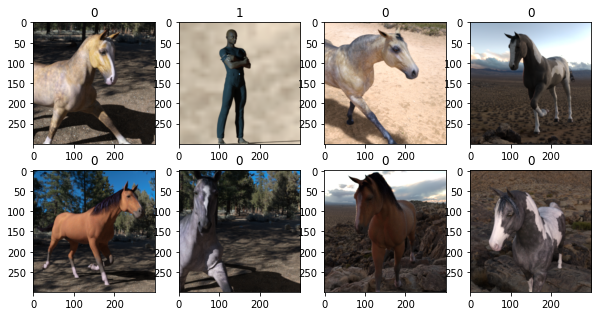

In [109]:
# show some dataset examples

ROWS, COLS = 2, 4
samples = []
labels = []

for image, label in tfds.as_numpy(train_ds):
  samples.append(image)
  labels.append(label)
  if len(samples) == ROWS*COLS:
    break

f, axs = plt.subplots(ROWS,COLS)

a= 0

for i in range(ROWS):
  for j in range(COLS):
    axs[i,j].imshow(samples[a])
    axs[i,j].set_title(labels[a])
    a+=1

In [27]:
# function builds historam of local features with thier counts/frequency

def build_histogram(descriptor_list, kmeans):
    histogram = np.zeros(len(kmeans.cluster_centers_))
    cluster_result =  kmeans.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

# Extract Descriptors

In [6]:
# we create seperate BOVW for each class

BOVW1 = [] # horses
BOVW2 = [] # humans

# make list of descriptors

orb = cv2.ORB_create(200) # 200 descriptors

for i, (image, label) in enumerate(tfds.as_numpy(train_ds)):

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  _, descriptor = orb.detectAndCompute(gray, None)
  if label == 0:
    BOVW1.extend(descriptor)
  else:
    BOVW2.extend(descriptor)

# Make clusters with KMeans

In [41]:
# cluster them to 50 components

kmeans1 = KMeans(50, n_jobs=-1)
kmeans2 = KMeans(50, n_jobs=-1)

kmeans1.fit(BOVW1)
kmeans2.fit(BOVW2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=50, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Build histograms of train samples

In [42]:
# build histogram of train data using descriptors we extracted

# contains number of features per image(features frqeuncy in each image)
local_features1 = [] # features of horses historgrams
local_features2 = [] # features of humans historgrams

for desc in BOVW1:

  desc = np.array(desc).reshape(1, desc.shape[0])
  hist = build_histogram(desc, kmeans1)
  local_features1.append(hist)

for desc in BOVW2:

  desc = np.array(desc).reshape(1, desc.shape[0]) 
  hist = build_histogram(desc, kmeans2)
  local_features2.append(hist)


# Fit 2 KNN on these Histograms

In [43]:
# fit a knn, 25 closest neighbors

neighbor1 = NearestNeighbors(n_neighbors = 25) # 25 nearest features
neighbor1.fit(local_features1)

neighbor2 = NearestNeighbors(n_neighbors = 25) # 25 nearest features
neighbor2.fit(local_features2)


NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                 radius=1.0)

# Predict on Test set

In [89]:
# take 50 samples images and labels

samples = [image for image, label in tfds.as_numpy(test_ds)]
samples_lb = [label for image, label in tfds.as_numpy(test_ds)]

In [90]:
# find the neighbors distance that we will use to predict

dists1 = []
dists2 = []

for sample in samples:
  data = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
  _, descriptor = orb.detectAndCompute(data, None)

  hist1 = build_histogram(descriptor, kmeans1)
  hist2 = build_histogram(descriptor, kmeans2)

  dist1, _ = neighbor1.kneighbors([hist1])
  dist2, _ = neighbor2.kneighbors([hist2])

  dists1.append(dist1)
  dists2.append(dist2)
  

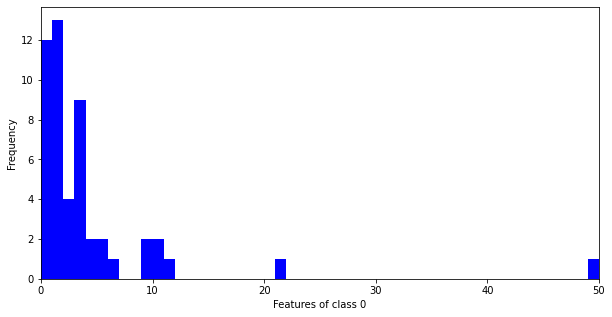

In [100]:
# sample image 1 histogram of both classes
# plot the histogram of features and thier frequency with kmeans 1 of single image

plt.hist(hist1, bins=50, color='b')
plt.xlim(0,50)
plt.xlabel('Features of class 0')
plt.ylabel('Frequency')
plt.show()

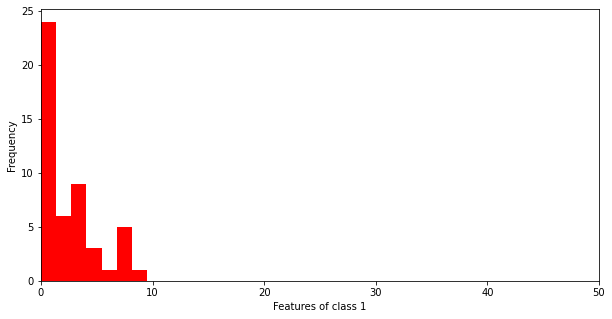

In [101]:
# plot the histogram of features and thier frequency with kmeans 1 of single image

plt.hist(hist2, bins=50, color='r')
plt.xlim(0,50)
plt.xlabel('Features of class 1')
plt.ylabel('Frequency')
plt.show()

# Print Results

Actual: Horse
Results: Horse


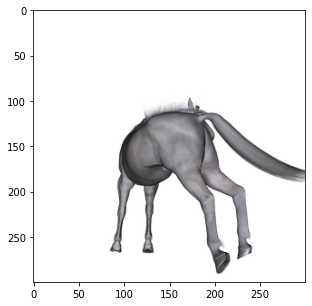

In [84]:
# sample show

if samples_lb[0] == 0:
  print('Actual: Horse')
else:
  print('Actual: Human')

if np.sum(dist1[0] > dist2[0]) > np.sum(dist1[0] < dist2[0]):
  print('Results: Horse')
else:
  print('Results: Human')

plt.imshow(samples[0])
plt.show()

In [99]:
# print results

results = 0

for dist1,dist2,actual in zip(dists1, dists2, samples_lb):

  if np.sum(dist1 > dist2) > np.sum(dist1 < dist2):
    if actual == 0:
      results+=1

  else:
    if actual == 1:
      results+=1

print('Predicted {0} correct of {1}'.format(results, len(samples_lb)))
print('Accuracy:', results/len(samples_lb)*100)

Predicted 21 correct of 50
Accuracy: 42.0


Summary:
We achieved an accuracy of 42 percent with this method. As this method is old but still is capable of predicting. On some results on complex images with heavy backgrounds this method may not perform well. To further improve we can:
*  Use more training data.
*  More clustures of descriptors.
*  Use RandomizedSearchCV to search hyperparameters(n_clusters, n_nieghbors of KNN, KMeans).
*  Use Deep Learning.